## References
- [1] Erlingsson, Pihur, and Korolova (2014) "RAPPOR: Randomized aggregatable privacy-preserving ordinal response" (ACM CCS).
- [2] Arcolezi et al (2022) "Improving the Utility of Locally Differentially Private Protocols for Longitudinal and Multidimensional Frequency Estimates" (Digital Communications and Networks).
- [3] Ding et al (2017) "Collecting telemetry data privately" (NIPS).

In [1]:
frac = 0.05 # (reduced dataset) frac=1 for results in the paper, i.e., whole dataset
nb_seed = 5 # nb_seed=20 for results in the paper

In [2]:
import warnings; warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib
params = {'axes.titlesize':'20','xtick.labelsize':'20','ytick.labelsize':'20','font.size':'18', 'legend.fontsize':'medium', 'lines.linewidth':'2.5', 'font.weight':'normal','lines.markersize':'16', 'text.latex.preamble': r'\usepackage{amsfonts}', 'lines.markerfacecolor':'none'}
matplotlib.rcParams.update(params)
plt.rcParams["mathtext.fontset"] = "cm"
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

from sys import maxsize
import time
import numpy as np
import xxhash
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

## Importing protocols

In [3]:
# Seeding function to ensure reproducibility
from LDP.protocols import setting_seed
# Our protocols
from LDP.protocols import LOLOHA_Client, LOLOHA_Aggregator
# Competitors
from LDP.protocols import RAPPOR_Client, RAPPOR_Aggregator # [1]
from LDP.protocols import L_OSUE_Client, L_OSUE_Aggregator # [2]
from LDP.protocols import L_GRR_Client, L_GRR_Aggregator # [2]
from LDP.protocols import dBitFlipPM_Client, dBitFlipPM_Aggregator # [3]

## Reading Adult dataset

In [4]:
tau = 52 * 5 # nb of weeks in 5 years

usecol = 'hours-per-week'
df = pd.read_csv('datasets/Adult.csv', usecols=[usecol])
for i in range(tau): # random permutation for each t \in [\tau]
    df[i] = df[usecol].sample(frac=1, random_state=i).values
del df[usecol]
df

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,259
0,45,49,40,40,55,40,50,10,44,48,...,50,15,40,40,40,50,52,42,50,40
1,55,35,20,15,99,40,45,50,35,40,...,38,48,40,7,70,40,40,40,25,40
2,38,60,40,45,40,40,35,35,40,36,...,30,40,40,48,40,40,40,40,40,45
3,40,40,40,35,50,25,55,43,50,40,...,15,40,42,35,20,40,60,40,40,48
4,40,40,75,30,40,38,40,38,65,40,...,35,35,35,40,40,40,40,52,60,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45217,40,50,50,40,40,45,40,40,70,40,...,40,40,40,20,70,20,40,44,40,43
45218,60,40,40,40,40,50,40,16,50,40,...,40,40,40,40,40,52,15,40,40,40
45219,55,32,40,55,50,28,40,58,35,40,...,46,40,30,40,37,35,50,16,40,40
45220,40,20,61,40,50,40,45,40,38,45,...,50,40,40,45,57,40,25,7,15,40


## Encoding

In [5]:
LE = LabelEncoder()
LE.fit(np.array([val for col in df.columns for val in df[col]])) # considering all unique values

for col in df.columns:
    df[col] = LE.transform(df[col])

df = df.sample(frac=frac) # to decrease execution time, we'll use frac% of the dataset
df.reset_index(inplace=True, drop=True)
df

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,259
0,81,34,44,39,39,49,49,39,37,54,...,39,64,39,41,52,39,39,39,3,69
1,19,44,39,35,39,39,26,39,39,39,...,39,59,39,39,59,39,59,49,19,39
2,39,59,34,49,39,39,49,39,59,41,...,39,14,39,49,37,49,39,47,39,44
3,37,44,11,31,39,49,39,11,19,39,...,39,29,39,46,39,39,43,39,39,39
4,39,29,49,39,19,39,34,34,59,44,...,39,14,39,39,39,59,39,64,39,76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2256,11,39,48,39,39,19,39,39,49,39,...,49,39,51,39,39,39,49,39,59,43
2257,39,39,39,59,39,34,54,39,39,9,...,34,39,59,39,3,39,39,39,39,39
2258,49,11,64,39,44,34,39,39,49,19,...,39,39,49,17,49,39,39,39,59,39
2259,39,39,59,39,19,39,36,47,54,54,...,11,44,51,45,39,39,29,39,19,39


## Static Parameteres

In [6]:
# number of users (n)
n = df.shape[0]
print('Number of Users =',n)

# number of data collections (tau)
tau = df.shape[1]

# attribute's domain size
k = len(LE.classes_)
print("\nAttribute's domain size =", k)

print('\ndBitFlipPM parameters')
b = k
print("Number of bukects b:", b)

bulk_size = k / b
print("Bucket size:", bulk_size)

print("\nPrivacy guarantees:")

# upper bound (infinity reports)
lst_eps_perm = np.arange(0.5, 5.1, 0.5)
print("List of epsilon_perm =", lst_eps_perm)

# alpha value
alpha = 0.4
print("alpha =", alpha)

Number of Users = 2261

Attribute's domain size = 96

dBitFlipPM parameters
Number of bukects b: 96
Bucket size: 1.0

Privacy guarantees:
List of epsilon_perm = [0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
alpha = 0.4


## Real frequency for each data collection $t \in [\tau]$

In [7]:
dic_real = {t:0 for t in range(1)} # for Adult dataset, the real frequency is the same for all t \in [\tau]
for t in range(1):
    real_freq = np.zeros(k)
    for val in df[t].values:
        real_freq[val]+=1
    real_freq = real_freq / sum(real_freq)
    dic_real[t] = real_freq
dic_real

{0: array([0.00000000e+00, 8.84564352e-04, 1.32684653e-03, 8.84564352e-04,
        2.21141088e-03, 1.76912870e-03, 8.84564352e-04, 1.32684653e-03,
        0.00000000e+00, 8.84564352e-03, 4.42282176e-04, 6.19195046e-03,
        8.84564352e-04, 4.42282176e-04, 1.32684653e-02, 6.19195046e-03,
        4.42282176e-04, 2.65369306e-03, 0.00000000e+00, 3.58248563e-02,
        8.84564352e-04, 4.42282176e-04, 8.84564352e-04, 6.63423264e-03,
        2.12295444e-02, 8.84564352e-04, 8.84564352e-04, 1.32684653e-03,
        8.84564352e-04, 3.05174701e-02, 0.00000000e+00, 9.73020787e-03,
        1.32684653e-03, 1.32684653e-03, 4.11322424e-02, 6.19195046e-03,
        5.30738611e-03, 1.37107475e-02, 1.76912870e-03, 4.56877488e-01,
        8.84564352e-04, 1.01724900e-02, 3.53825741e-03, 7.51879699e-03,
        5.79389651e-02, 3.09597523e-03, 1.76912870e-03, 1.45953118e-02,
        1.32684653e-03, 9.59752322e-02, 4.42282176e-04, 4.86510394e-03,
        4.42282176e-04, 1.32684653e-03, 2.60946484e-02, 4.422

## Take average results due to randomness

In [8]:
# Save MSE per seed
dic_mse = {seed: 
               {"OLOLOHA": [],
                "BiLOLOHA": [],
                "L_OSUE": [],
                "RAPPOR": [],
                "L_GRR": [],
                "1BitFlipPM": [],
                "bBitFlipPM": []
               } 
               for seed in range(nb_seed)
          }
# Save budget consumption per seed
dic_bdg = {seed: 
               {"OLOLOHA": -1,
                "BiLOLOHA": -1,
                "L_OSUE": -1,
                "RAPPOR": -1,
                "L_GRR": -1,
                "1BitFlipPM": -1,
                "bBitFlipPM": -1
               } 
               for seed in range(nb_seed)
          }

# Save data change detection per seed
dic_chg = {seed: 
               {
                "1BitFlipPM": -1,
                "bBitFlipPM": -1
               } 
               for seed in range(nb_seed)
          }

## OLOLOLHA

In [9]:
starttime = time.time()

for seed in range(nb_seed):
    print(seed)
    setting_seed(seed) # Ensure reproducibility
    np.random.seed(seed) # Ensure reproducibility
    
    lst_mse_avg = [] # List of averaged MSE per eps_perm
    lst_bdg_avg = [] # List of averaged budget consumption per eps_perm
    
    for eps_perm in lst_eps_perm: # Longitudinal privacy guarantee (upper bound)
        eps_1 = alpha * eps_perm # First report privacy guarantee (lower bound)
        
        # Client-Side
        reports = [] # List of reports of all n users
        budget_tracking = [] # List of consumed privacy budget of all n users
        for ind, row in df.iterrows():
            
            sanitized_reports, final_budget = LOLOHA_Client(row.values, k, eps_perm, eps_1, alpha, optimal=True)
            reports.append(sanitized_reports)
            budget_tracking.append(final_budget)
        
        reports = np.array(reports)
        
        # Server-Side
        lst_mse = [] # List of all MSE per data collection
        for t in range(tau): # For each data collection
            
            real_freq = dic_real[0] # for Adult dataset, the real frequency is the same for all t \in [\tau]
            est_freq = LOLOHA_Aggregator(reports[:, t], k, eps_perm, eps_1, alpha, optimal=True)
            lst_mse.append(mean_squared_error(real_freq, est_freq))
        
        lst_mse_avg.append(np.mean(lst_mse)) # Averaged MSE
        lst_bdg_avg.append(np.mean(budget_tracking)) # Averaged privacy budget consumption
    
    dic_mse[seed]["OLOLOHA"] = lst_mse_avg
    dic_bdg[seed]["OLOLOHA"] = lst_bdg_avg
    
print('That took {} seconds'.format(time.time() - starttime))

0
1
2
3
4
That took 6863.70289850235 seconds


## BiLOLOHA

In [10]:
starttime = time.time()

for seed in range(nb_seed):
    print(seed)
    setting_seed(seed) # Ensure reproducibility
    np.random.seed(seed) # Ensure reproducibility
    
    lst_mse_avg = [] # List of averaged MSE per eps_perm
    lst_bdg_avg = [] # List of averaged budget consumption per eps_perm
    
    for eps_perm in lst_eps_perm: # Longitudinal privacy guarantee (upper bound)
        eps_1 = alpha * eps_perm # First report privacy guarantee (lower bound)
        
        # Client-Side
        reports = [] # List of reports of all n users
        budget_tracking = [] # List of consumed privacy budget of all n users
        for ind, row in df.iterrows():
            
            sanitized_reports, final_budget = LOLOHA_Client(row.values, k, eps_perm, eps_1, alpha, optimal=False)
            reports.append(sanitized_reports)
            budget_tracking.append(final_budget)
        
        reports = np.array(reports)
        
        # Server-Side
        lst_mse = [] # List of all MSE per data collection
        for t in range(tau): # For each data collection
            
            real_freq = dic_real[0] # for Adult dataset, the real frequency is the same for all t \in [\tau]
            est_freq = LOLOHA_Aggregator(reports[:, t], k, eps_perm, eps_1, alpha, optimal=False)
            lst_mse.append(mean_squared_error(real_freq, est_freq))
        
        lst_mse_avg.append(np.mean(lst_mse)) # Averaged MSE
        lst_bdg_avg.append(np.mean(budget_tracking)) # Averaged privacy budget consumption
        
    dic_mse[seed]["BiLOLOHA"] = lst_mse_avg
    dic_bdg[seed]["BiLOLOHA"] = lst_bdg_avg
    
print('That took {} seconds'.format(time.time() - starttime))    

0
1
2
3
4
That took 3488.4204757213593 seconds


## L-OSUE [2]

In [11]:
starttime = time.time()

for seed in range(nb_seed):
    print(seed)
    setting_seed(seed) # Ensure reproducibility
    np.random.seed(seed) # Ensure reproducibility
    
    lst_mse_avg = [] # List of averaged MSE per eps_perm
    lst_bdg_avg = [] # List of averaged budget consumption per eps_perm
    
    for eps_perm in lst_eps_perm: # Longitudinal privacy guarantee (upper bound)
        eps_1 = alpha * eps_perm # First report privacy guarantee (lower bound)
        
        # Client-Side
        reports = [] # List of reports of all n users
        budget_tracking = [] # List of consumed privacy budget of all n users
        for ind, row in df.iterrows():
            
            sanitized_reports, final_budget = L_OSUE_Client(row.values, k, eps_perm, eps_1)
            reports.append(sanitized_reports)
            budget_tracking.append(final_budget)
        
        reports = np.array(reports)
        
        # Server-Side
        lst_mse = [] # List of all MSE per data collection
        for t in range(tau): # For each data collection
            
            real_freq = dic_real[0] # for Adult dataset, the real frequency is the same for all t \in [\tau]
            est_freq = L_OSUE_Aggregator(reports[:, t], eps_perm, eps_1)
            lst_mse.append(mean_squared_error(real_freq, est_freq))
        
        lst_mse_avg.append(np.mean(lst_mse)) # Averaged MSE
        lst_bdg_avg.append(np.mean(budget_tracking)) # Averaged privacy budget consumption
        
    dic_mse[seed]["L_OSUE"] = lst_mse_avg
    dic_bdg[seed]["L_OSUE"] = lst_bdg_avg
    
print('That took {} seconds'.format(time.time() - starttime))

0
1
2
3
4
That took 202.3296763896942 seconds


## RAPPOR [1]

In [12]:
starttime = time.time()

for seed in range(nb_seed):
    print(seed)
    setting_seed(seed) # Ensure reproducibility
    np.random.seed(seed) # Ensure reproducibility
    
    lst_mse_avg = [] # List of averaged MSE per eps_perm
    lst_bdg_avg = [] # List of averaged budget consumption per eps_perm
    
    for eps_perm in lst_eps_perm: # Longitudinal privacy guarantee (upper bound)
        eps_1 = alpha * eps_perm # First report privacy guarantee (lower bound)
        
        # Client-Side
        reports = [] # List of reports of all n users
        budget_tracking = [] # List of consumed privacy budget of all n users
        for ind, row in df.iterrows():
            
            sanitized_reports, final_budget = RAPPOR_Client(row.values, k, eps_perm, eps_1)
            reports.append(sanitized_reports)
            budget_tracking.append(final_budget)
        
        reports = np.array(reports)
        
        # Server-Side
        lst_mse = [] # List of all MSE per data collection
        for t in range(tau): # For each data collection
            
            real_freq = dic_real[0] # for Adult dataset, the real frequency is the same for all t \in [\tau]
            est_freq = RAPPOR_Aggregator(reports[:, t], eps_perm, eps_1)
            lst_mse.append(mean_squared_error(real_freq, est_freq))
        
        lst_mse_avg.append(np.mean(lst_mse)) # Averaged MSE
        lst_bdg_avg.append(np.mean(budget_tracking)) # Averaged privacy budget consumption
        
    dic_mse[seed]["RAPPOR"] = lst_mse_avg
    dic_bdg[seed]["RAPPOR"] = lst_bdg_avg
    
print('That took {} seconds'.format(time.time() - starttime))    

0
1
2
3
4
That took 213.9933488368988 seconds


## L-GRR [2]

In [13]:
starttime = time.time()

for seed in range(nb_seed):
    print(seed)
    setting_seed(seed) # Ensure reproducibility
    np.random.seed(seed) # Ensure reproducibility
    
    lst_mse_avg = [] # List of averaged MSE per eps_perm
    lst_bdg_avg = [] # List of averaged budget consumption per eps_perm
    
    for eps_perm in lst_eps_perm: # Longitudinal privacy guarantee (upper bound)
        eps_1 = alpha * eps_perm # First report privacy guarantee (lower bound)
        
        # Client-Side
        reports = [] # List of reports of all n users
        budget_tracking = [] # List of consumed privacy budget of all n users
        for ind, row in df.iterrows():
            
            sanitized_reports, final_budget = L_GRR_Client(row.values, k, eps_perm, eps_1)
            reports.append(sanitized_reports)
            budget_tracking.append(final_budget)
        
        reports = np.array(reports)
        
        # Server-Side
        lst_mse = [] # List of all MSE per data collection
        for t in range(tau): # For each data collection
            
            real_freq = dic_real[0] # for Adult dataset, the real frequency is the same for all t \in [\tau]
            est_freq = L_GRR_Aggregator(reports[:, t], k, eps_perm, eps_1)
            lst_mse.append(mean_squared_error(real_freq, est_freq))
        
        lst_mse_avg.append(np.mean(lst_mse)) # Averaged MSE
        lst_bdg_avg.append(np.mean(budget_tracking)) # Averaged privacy budget consumption
        
    dic_mse[seed]["L_GRR"] = lst_mse_avg
    dic_bdg[seed]["L_GRR"] = lst_bdg_avg
    
print('That took {} seconds'.format(time.time() - starttime))    

0
1
2
3
4
That took 162.1397569179535 seconds


## 1BitFlipPM [3]

In [14]:
starttime = time.time()

# Number of bits each user sample/report
d = 1

for seed in range(nb_seed):
    print(seed)
    np.random.seed(seed) # Ensure reproducibility
    
    lst_mse_avg = [] # List of averaged MSE per eps_perm
    lst_bdg_avg = [] # List of averaged budget consumption per eps_perm
    lst_detect_change = [] # List of 100% detected change
    
    for eps_perm in lst_eps_perm: # Longitudinal privacy guarantee (upper bound)
        
        # Client-Side
        reports = [] # List of reports of all n users
        budget_tracking = [] # List of consumed privacy budget of all n users
        change_tracking = [] # List of Boolean value indicating data change detection for all values
        for ind, row in df.iterrows():
            
            sanitized_reports, final_budget, detect_change = dBitFlipPM_Client(row.values, k, b, d, eps_perm)
            reports.append(sanitized_reports)
            budget_tracking.append(final_budget)
            change_tracking.append(detect_change)
        
        reports = np.array(reports)
        
        # Server-Side
        lst_mse = [] # List of all MSE per data collection
        for t in range(tau): # For each data collection
            
            real_freq = np.zeros(b)
            for val in df[t].values:
                real_freq[int(val / bulk_size)]+=1
            real_freq = real_freq/sum(real_freq)
            
            est_freq = dBitFlipPM_Aggregator(reports[:, t], b, d, eps_perm)
            lst_mse.append(mean_squared_error(real_freq, est_freq))
        
        lst_mse_avg.append(np.mean(lst_mse)) # Averaged MSE
        lst_bdg_avg.append(np.mean(budget_tracking)) # Averaged privacy budget consumption
        lst_detect_change.append(100 * sum(change_tracking) / n) # Averaged data change detection in %
        
    dic_mse[seed]["1BitFlipPM"] = lst_mse_avg
    dic_bdg[seed]["1BitFlipPM"] = lst_bdg_avg
    dic_chg[seed]["1BitFlipPM"] = lst_detect_change
    
print('That took {} seconds'.format(time.time() - starttime))

0
1
2
3
4
That took 2870.205671787262 seconds


## bBitFlipPM [3]

In [15]:
starttime = time.time()

# Number of bits each user sample/report
d = b

for seed in range(nb_seed):
    print(seed)
    np.random.seed(seed) # Ensure reproducibility
    
    lst_mse_avg = [] # List of averaged MSE per eps_perm
    lst_bdg_avg = [] # List of averaged budget consumption per eps_perm
    lst_detect_change = [] # List of 100% detected change
    
    for eps_perm in lst_eps_perm: # Longitudinal privacy guarantee (upper bound)
        
        # Client-Side
        reports = [] # List of reports of all n users
        budget_tracking = [] # List of consumed privacy budget of all n users
        change_tracking = [] # List of Boolean value indicating data change detection for all values
        for ind, row in df.iterrows():
            
            sanitized_reports, final_budget, detect_change = dBitFlipPM_Client(row.values, k, b, d, eps_perm)
            reports.append(sanitized_reports)
            budget_tracking.append(final_budget)
            change_tracking.append(detect_change)
        
        reports = np.array(reports)
        
        # Server-Side
        lst_mse = [] # List of all MSE per data collection
        for t in range(tau): # For each data collection
            
            real_freq = np.zeros(b)
            for val in df[t].values:
                real_freq[int(val / bulk_size)]+=1
            real_freq = real_freq/sum(real_freq)
            
            est_freq = dBitFlipPM_Aggregator(reports[:, t], b, d, eps_perm)
            lst_mse.append(mean_squared_error(real_freq, est_freq))
        
        lst_mse_avg.append(np.mean(lst_mse)) # Averaged MSE
        lst_bdg_avg.append(np.mean(budget_tracking)) # Averaged privacy budget consumption
        lst_detect_change.append(100 * sum(change_tracking) / n) # Averaged data change detection in %
        
    dic_mse[seed]["bBitFlipPM"] = lst_mse_avg
    dic_bdg[seed]["bBitFlipPM"] = lst_bdg_avg
    dic_chg[seed]["bBitFlipPM"] = lst_detect_change
    
print('That took {} seconds'.format(time.time() - starttime))

0
1
2
3
4
That took 12800.07363319397 seconds


## Plotting MSE_avg metric results

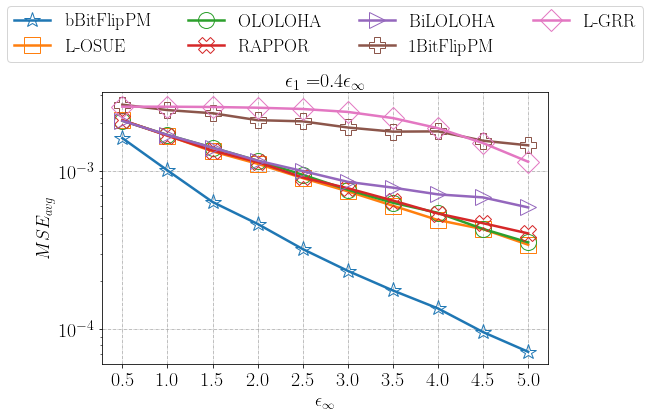

In [16]:
plt.figure(figsize=(8,5))
plt.grid(color='grey', linestyle='dashdot', linewidth=0.5)
plt.plot(np.mean([dic_mse[seed]["bBitFlipPM"] for seed in range(nb_seed)], axis=0), label='bBitFlipPM', marker='*')
plt.plot(np.mean([dic_mse[seed]["L_OSUE"] for seed in range(nb_seed)], axis=0), label='L-OSUE',marker='s')
plt.plot(np.mean([dic_mse[seed]["OLOLOHA"] for seed in range(nb_seed)], axis=0), label='OLOLOHA', marker='o')
plt.plot(np.mean([dic_mse[seed]["RAPPOR"] for seed in range(nb_seed)], axis=0), label='RAPPOR',marker='X')
plt.plot(np.mean([dic_mse[seed]["BiLOLOHA"] for seed in range(nb_seed)], axis=0), label='BiLOLOHA',marker='>')
plt.plot(np.mean([dic_mse[seed]["1BitFlipPM"] for seed in range(nb_seed)], axis=0), label='1BitFlipPM', marker='P')
plt.plot(np.mean([dic_mse[seed]["L_GRR"] for seed in range(nb_seed)], axis=0), label='L-GRR', marker='D')

plt.yscale('log')
plt.xlabel('$\epsilon_{\infty}$')
plt.ylabel('$MSE_{avg}$')
plt.xticks(range(len(lst_eps_perm)), lst_eps_perm)
plt.title('$\epsilon_1$ $=$' +f'${alpha}$'+ '$\epsilon_{\infty}$', loc='center')
plt.legend(ncol=4, loc='upper center', bbox_to_anchor=(0.5, 1.35))
plt.show()

## Plotting privacy budget consumption metric results

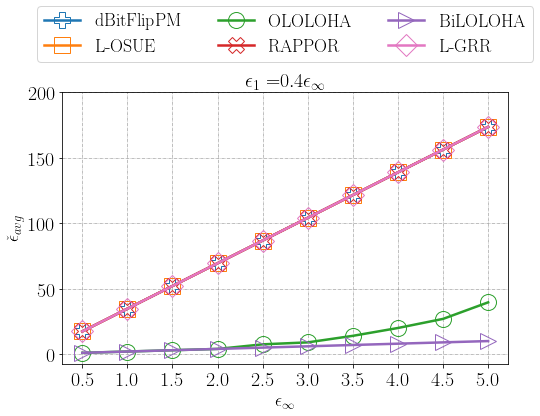

In [20]:
plt.figure(figsize=(8,5))
plt.grid(color='grey', linestyle='dashdot', linewidth=0.5)
plt.plot(np.mean([dic_bdg[seed]["1BitFlipPM"] for seed in range(nb_seed)], axis=0)*lst_eps_perm, label='dBitFlipPM', marker='P')
plt.plot(np.mean([dic_bdg[seed]["L_OSUE"] for seed in range(nb_seed)], axis=0)*lst_eps_perm, label='L-OSUE',marker='s')
plt.plot(np.mean([dic_bdg[seed]["OLOLOHA"] for seed in range(nb_seed)], axis=0)*lst_eps_perm, label='OLOLOHA', marker='o')
plt.plot(np.mean([dic_bdg[seed]["RAPPOR"] for seed in range(nb_seed)], axis=0)*lst_eps_perm, label='RAPPOR',marker='X')
plt.plot(np.mean([dic_bdg[seed]["BiLOLOHA"] for seed in range(nb_seed)], axis=0)*lst_eps_perm, label='BiLOLOHA',marker='>')
plt.plot(np.mean([dic_bdg[seed]["L_GRR"] for seed in range(nb_seed)], axis=0)*lst_eps_perm, label='L-GRR', marker='D', color='tab:pink')


ticks = np.arange(0,201,50)
plt.yticks(ticks,ticks)
# plt.set_yticklabels()
plt.xlabel('$\epsilon_{\infty}$')
plt.ylabel('$\check{\epsilon}_{avg}$')
plt.xticks(range(len(lst_eps_perm)), lst_eps_perm)
plt.title('$\epsilon_1$ $=$' +f'${alpha}$'+ '$\epsilon_{\infty}$', loc='center')
plt.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, 1.35))
plt.show()

## Plotting data change detection for dBitFlipPM

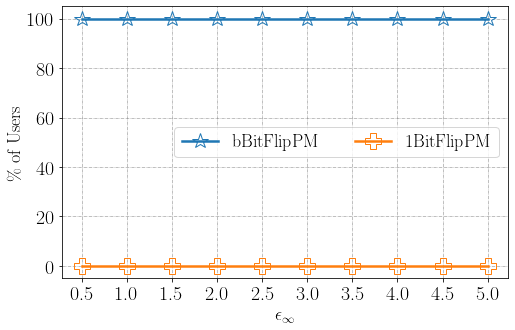

In [18]:
plt.figure(figsize=(8,5))
plt.grid(color='grey', linestyle='dashdot', linewidth=0.5)
plt.plot(np.mean([dic_chg[seed]["bBitFlipPM"] for seed in range(nb_seed)], axis=0), label='bBitFlipPM', marker='*')
plt.plot(np.mean([dic_chg[seed]["1BitFlipPM"] for seed in range(nb_seed)], axis=0), label='1BitFlipPM', marker='P')
# plt.yscale('log')
plt.xlabel('$\epsilon_{\infty}$')
plt.ylabel('\% of Users')
plt.xticks(range(len(lst_eps_perm)), lst_eps_perm)
plt.legend(ncol=2)
plt.show()